In [ ]:
!pip install scikit-image
!pip install gudhi
!pip install SimpleITK
!pip install nibabel


In [ ]:
# Let's start by downloading all necessary libraries
!pip install opencv-python-headless

# import all libraries
import numpy as np
import os
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import cv2
from pathlib import Path
import cv2
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from pathlib import Path
import tensorflow as tf
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from pathlib import Path
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import os
import cv2
import torch
import torch.nn as nn
#import cupy as cp
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from gudhi import CubicalComplex
from skimage import exposure, feature, filters
#from skimage.feature import greycomatrix, greycoprops
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, wasserstein_distance
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from scipy.stats import wasserstein_distance, entropy
from scipy.spatial.distance import jensenshannon


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the directory path for saving features
save_dir = '/content/drive/My Drive/Scorecard_Results/NonDeepFeatures'
os.makedirs(save_dir, exist_ok=True)

# List of datasets provided
datasets = {
    #'VinDr': '/content/drive/My Drive/Mammography_data_RS/Real_Mammography_Data/converted_HE_VinDr_images',
    #'DDSM': '/content/drive/My Drive/Mammography_data_RS/Real_Mammography_Data/DDSM_all_images_cropped/DDSM_images_resized/DDSM_all_clean_all/center_cropped/equalized_images',
    'InBreast': '/content/drive/My Drive/Mammography_data_RS/Real_Mammography_Data/INbreast_cropped_DICOM_images/INbreast_cropped_DICOM_images_resized/center_cropped/equalized_images',
    #'MIAS': '/content/drive/My Drive/Mammography_data_RS/Real_Mammography_Data/all-mias_cropped_images/all-mias_cropped_images_resized/center_cropped_clean_all_mias/equalized_images',
    'MSYNTH': '/content/drive/My Drive/Mammography_data_RS/SMD_datasets/All_images_Elena/Elena_images_resized/equalized_images',
    #'HuggingFace': '/content/drive/My Drive/Mammography_data_RS/SMD_datasets/HF_synthetic_mammography_csaw /center_cropped',
    #'Mammo_medigan': '/content/drive/My Drive/Mammography_data_RS/SMD_datasets/Mammo_medigan/medigan_images_resized/center_cropped'
}


def compute_features(image_array):
    # Histogram-based features
    mean_val = np.mean(image_array)
    std_val = np.std(image_array)
    skewness = stats.skew(image_array.flatten())
    kurtosis = stats.kurtosis(image_array.flatten())
    median_val = np.median(image_array)

    # Edge-based features
    edges = feature.canny(image_array)
    edge_density = np.sum(edges) / edges.size
    avg_edge_intensity = np.mean(image_array[edges])

    # Fourier transform features
    f_transform = np.fft.fft2(image_array)
    f_transform_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shift)
    low_freq_energy = np.sum(magnitude_spectrum[:10, :10])
    high_freq_energy = np.sum(magnitude_spectrum[-10:, -10:])

    # Topological features using Persistent Homology
    cubical_complex = CubicalComplex(dimensions=image_array.shape, top_dimensional_cells=image_array.flatten())
    persistence = cubical_complex.persistence()
    betti_0 = sum(1 for p in persistence if p[0] == 0)
    betti_1 = sum(1 for p in persistence if p[0] == 1)

    features = [mean_val, std_val, skewness, kurtosis, median_val,
                edge_density, avg_edge_intensity, low_freq_energy, high_freq_energy,
                betti_0, betti_1]

    return features

# Define the feature columns
feature_columns = [
    'mean', 'std', 'skewness', 'kurtosis', 'median',
    'edge_density', 'avg_edge_intensity', 'low_freq_energy', 'high_freq_energy',
    'betti_0', 'betti_1'
]

In [ ]:
# Initialize a dictionary to store features for each dataset
dataset_features = {}

# Extract features for each dataset and save to the specified folder
for dataset_name, dataset_path in datasets.items():
    image_features = []
    all_files = [os.path.join(root, file)
                 for root, _, files in os.walk(dataset_path)
                 for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dicom', '.dcm'))]

    # Iterate through the selected image files with a progress bar
    for image_path in tqdm(all_files, desc=f'Processing {dataset_name}', unit='file'):
        img = Image.open(image_path).convert('L')
        img_array = np.array(img)
        features = compute_features(img_array)
        image_features.append(features)

    # Store extracted features in a DataFrame and save to CSV
    dataset_df = pd.DataFrame(image_features, columns=feature_columns)
    output_path = os.path.join(save_dir, f'{dataset_name}_features.csv')
    dataset_df.to_csv(output_path, index=False)
    dataset_features[dataset_name] = dataset_df

# Print summary information if needed
for dataset_name, features_df in dataset_features.items():
    print(f"Extracted features for {dataset_name}:")
    print(features_df.head())

Processing MSYNTH: 100%|██████████| 163/163 [02:45<00:00,  1.02s/file]


Extracted features for InBreast:
        mean        std  skewness  kurtosis  median  edge_density  \
0  56.298126  62.898512  0.482760 -1.442687     3.0      0.068466   
1  59.195412  71.462857  0.622911 -1.328548     3.0      0.073219   
2  42.668411  68.008423  1.217223 -0.342226     3.0      0.057301   
3  48.193787  72.603122  1.070732 -0.679632     3.0      0.063328   
4  40.330631  71.356542  1.485007  0.401871     3.0      0.049744   

   avg_edge_intensity  low_freq_energy  high_freq_energy  betti_0  betti_1  
0          127.085915     27846.212816      28451.562845     3386     5211  
1          143.634469     29041.748029      27658.890899     3173     5123  
2          148.205313     21369.225894      23852.833975     1848     3352  
3          154.031564     27194.962827      26016.714808     2080     3660  
4          161.980368     25278.828364      25607.295486     1821     3047  
Extracted features for MSYNTH:
        mean        std  skewness  kurtosis  median  edge_d

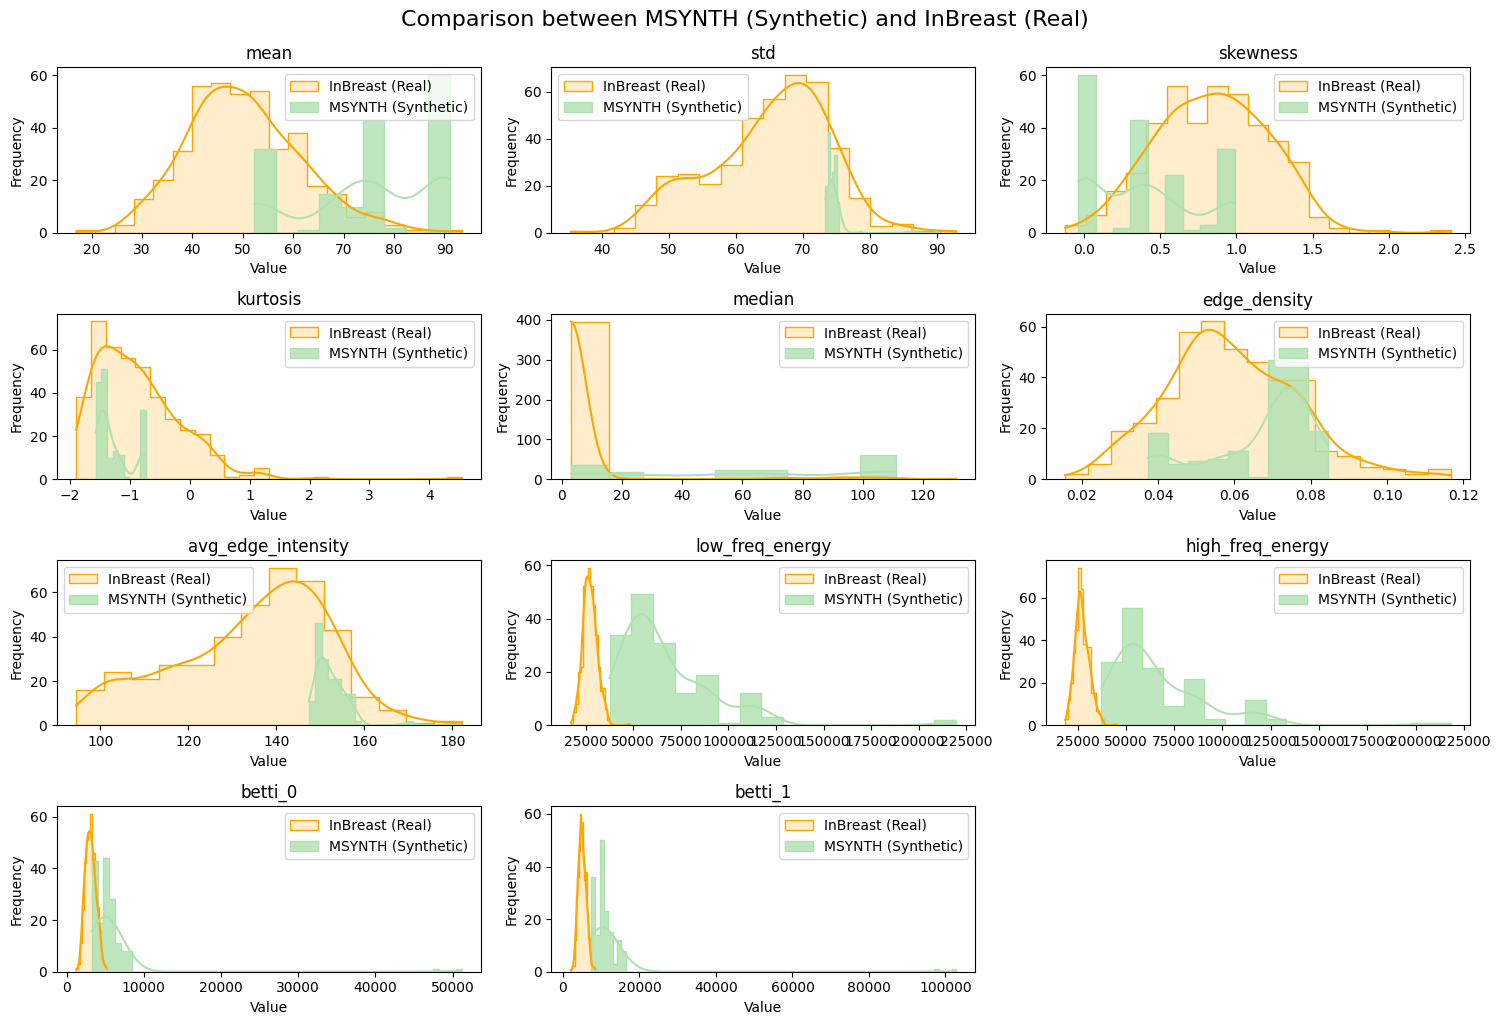

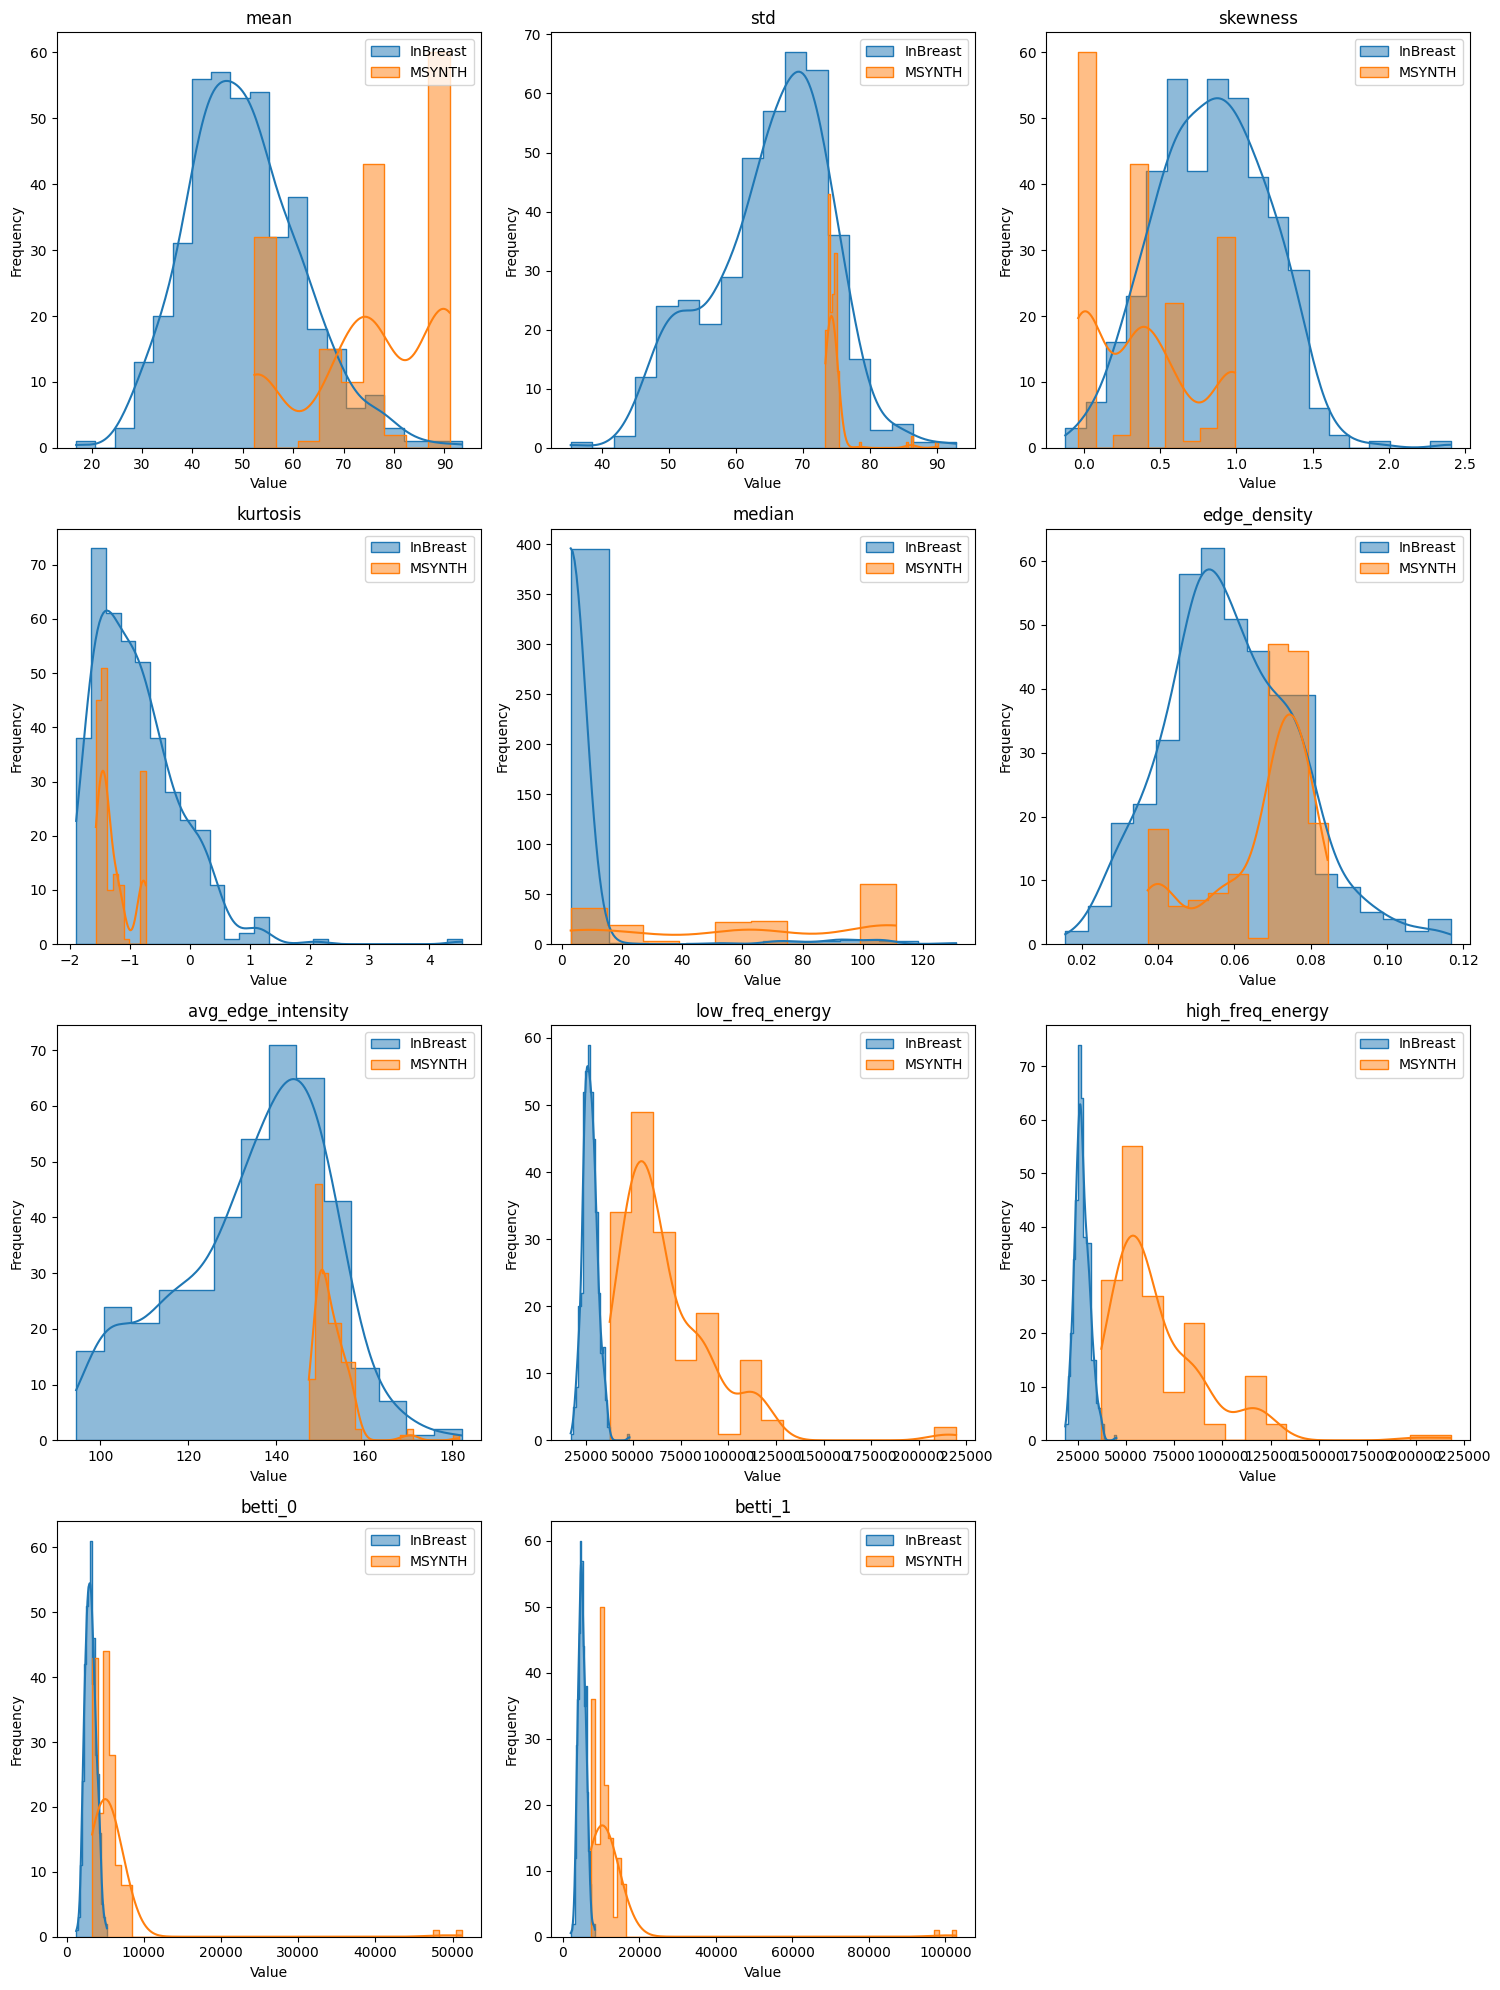

In [ ]:
# Define groups of synthetic and real datasets
#synthetic_datasets = ['MSYNTH', 'HuggingFace', 'Mammo_medigan']
#real_datasets = ['VinDr', 'DDSM', 'InBreast', 'MIAS']


synthetic_datasets = ['MSYNTH']
real_datasets = ['InBreast']

# Visualization parameters
real_transparency = 0.2  # Adjust transparency for real datasets
synthetic_color = '#AFE1AF'  # Distinctive color for synthetic datasets
figsize = (15, 10)  # Figure size for plots

# Function to plot comparison between synthetic and real datasets
def plot_synthetic_vs_real(synthetic, real):
    plt.figure(figsize=figsize)
    for i, column in enumerate(feature_columns):
        plt.subplot(4, 3, i + 1)  # Adjust grid size according to number of features
        # Plot real dataset histogram
        sns.histplot(dataset_features[real][column], kde=True, element='step',
                     label=f'{real} (Real)', color='orange', alpha=real_transparency)
        # Plot synthetic dataset histogram
        sns.histplot(dataset_features[synthetic][column], kde=True, element='step',
                     label=f'{synthetic} (Synthetic)', color=synthetic_color, alpha=0.8)
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.suptitle(f'Comparison between {synthetic} (Synthetic) and {real} (Real)', fontsize=16, y=1.02)
    plt.show()

def plot_all_datasets():
    plt.figure(figsize=(15, 20))  # Adjust size to better fit a larger grid
    for i, column in enumerate(feature_columns):
        plt.subplot(4, 3, i + 1)  # Adjust to a 4x3 grid
        for dataset_name, dataset_df in dataset_features.items():
            sns.histplot(dataset_df[column], label=dataset_name, kde=True, element='step')
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()



# Plot comparisons between synthetic and real datasets
for synthetic in synthetic_datasets:
    for real in real_datasets:
        plot_synthetic_vs_real(synthetic, real)

# Plot all datasets together
plot_all_datasets()


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import entropy, ks_2samp, cramervonmises_2samp, anderson_ksamp
from sklearn.metrics.pairwise import cosine_similarity
from cleanfid import fid
from tqdm import tqdm

# Define the directory path for saving features
save_dir = '/content/drive/My Drive/Scorecard_Results/Physics-based features'

# Load features from CSV files
def load_features(dataset_name):
    return pd.read_csv(os.path.join(save_dir, f"{dataset_name}_features.csv"))

# Replace the FID computation with clean-fid
def compute_fid_with_cleanfid(real_images_dir, synthetic_images_dir):
    """
    Compute FID score using clean-fid.
    """
    fid_score = fid.compute_fid(real_images_dir, synthetic_images_dir)
    return fid_score

# Keep the other metrics computation functions (e.g., KID, JSD, etc.)
def compute_kid(real_features, synthetic_features):
    kid = np.mean(np.dot(real_features, real_features.T)) + \
          np.mean(np.dot(synthetic_features, synthetic_features.T)) - \
          2 * np.mean(np.dot(real_features, synthetic_features.T))
    return kid

# Example: Compute FID using clean-fid
# Paths to real and synthetic images (required for clean-fid)

# Compute the FID score
fid_score = compute_fid_with_cleanfid(real_images_dir, synthetic_images_dir)

# Display FID score
print(f"FID Score (clean-fid): {fid_score}")

# Compute other metrics (example setup for KID, JSD, etc.)
real_features = load_features('InBreast').values
synthetic_features = load_features('MSYNTH').values

# Ensure features match in size
min_length = min(len(real_features), len(synthetic_features))
real_features = real_features[:min_length]
synthetic_features = synthetic_features[:min_length]

# Example: Compute KID
kid_score = compute_kid(real_features, synthetic_features)
print(f"KID Score: {kid_score}")

# Additional metrics can be computed in a similar manner


ModuleNotFoundError: No module named 'cleanfid'

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import entropy, ks_2samp, cramervonmises_2samp, anderson_ksamp
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import sqrtm
from tqdm import tqdm

# Define the directory path for saving features
save_dir = '/content/drive/My Drive/Scorecard_Results/Physics-based features'

# Load features from CSV files
def load_features(dataset_name):
    return pd.read_csv(os.path.join(save_dir, f"{dataset_name}_features.csv"))

# Normalize features
def normalize_features(features):
    epsilon = 1e-8
    return (features - np.min(features, axis=0)) / (np.max(features, axis=0) - np.min(features, axis=0) + epsilon)

def compute_fid(real_features, synthetic_features):
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(synthetic_features, axis=0), np.cov(synthetic_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def compute_kid(real_features, synthetic_features):
    kid = np.mean(np.dot(real_features, real_features.T)) + np.mean(np.dot(synthetic_features, synthetic_features.T)) - 2 * np.mean(np.dot(real_features, synthetic_features.T))
    return kid

def compute_jsd(real_features, synthetic_features):
    def _jsd(p, q):
        p = np.asarray(p)
        q = np.asarray(q)
        m = 0.5 * (p + q)
        return 0.5 * (entropy(p, m) + entropy(q, m))

    min_length = min(len(real_features), len(synthetic_features))
    real_features = real_features[:min_length]
    synthetic_features = synthetic_features[:min_length]

    return np.mean([_jsd(real_features[i], synthetic_features[i]) for i in range(min_length)])

def compute_emd(real_features, synthetic_features):
    emd = cdist(real_features, synthetic_features, metric='euclidean')
    return np.mean(emd)

def compute_kld(real_features, synthetic_features):
    p = np.mean(real_features, axis=0)
    q = np.mean(synthetic_features, axis=0)
    kld = entropy(p, q)
    return kld

def compute_ks(real_features, synthetic_features):
    ks_stat, ks_pvalue = ks_2samp(real_features.flatten(), synthetic_features.flatten())
    return ks_stat, ks_pvalue

def compute_cramervonmises(real_features, synthetic_features):
    cvm_stat = cramervonmises_2samp(real_features.flatten(), synthetic_features.flatten())
    return cvm_stat.statistic

def compute_andersondarling(real_features, synthetic_features):
    ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.flatten()])
    return ad_stat.statistic

def compute_bhattacharyya(real_features, synthetic_features):
    mean1 = np.mean(real_features, axis=0)
    mean2 = np.mean(synthetic_features, axis=0)
    cov1 = np.cov(real_features, rowvar=False)
    cov2 = np.cov(synthetic_features, rowvar=False)
    covmean = (cov1 + cov2) / 2
    diff = mean1 - mean2
    bhattacharyya = 0.125 * np.dot(np.dot(diff.T, np.linalg.inv(covmean)), diff) + 0.5 * np.log(np.linalg.det(covmean) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    return bhattacharyya

def compute_hellinger(real_features, synthetic_features):
    p = np.mean(real_features, axis=0)
    q = np.mean(synthetic_features, axis=0)
    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))
    return hellinger

def compute_cosine_similarity(real_features, synthetic_features):
    cosine_sim = cosine_similarity(real_features, synthetic_features)
    return np.mean(cosine_sim)

# Define synthetic and real datasets
synthetic_datasets = ['MSYNTH']
real_datasets = ['InBreast']

# Compute and store metrics
results = []

for real_dataset in real_datasets:
    real_features = normalize_features(load_features(real_dataset).values)
    for synthetic_dataset in synthetic_datasets:
        synthetic_features = normalize_features(load_features(synthetic_dataset).values)

        # Ensure the number of features match
        min_length = min(len(real_features), len(synthetic_features))
        real_features = real_features[:min_length]
        synthetic_features = synthetic_features[:min_length]

        metrics = {
            'Real Dataset': real_dataset,
            'Synthetic Dataset': synthetic_dataset,
            'FID': compute_fid(real_features, synthetic_features),
            'KID': compute_kid(real_features, synthetic_features),
            'JSD': compute_jsd(real_features, synthetic_features),
            'EMD': compute_emd(real_features, synthetic_features),
            'KLD': compute_kld(real_features, synthetic_features),
            'KS Statistic': compute_ks(real_features, synthetic_features)[0],
            'KS p-value': compute_ks(real_features, synthetic_features)[1],
            'Cramér-von Mises': compute_cramervonmises(real_features, synthetic_features),
            'Anderson-Darling': compute_andersondarling(real_features, synthetic_features),
            'Bhattacharyya': compute_bhattacharyya(real_features, synthetic_features),
            'Hellinger': compute_hellinger(real_features, synthetic_features),
            'Cosine Similarity': compute_cosine_similarity(real_features, synthetic_features)
        }

        results.append(metrics)

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Display results
print(df_results)

# Save results to CSV
df_results.to_csv(os.path.join(save_dir, "comparison_metrics.csv"), index=False)


<ipython-input-17-de7f686dbff6>:68: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.flatten()])


  Real Dataset Synthetic Dataset       FID       KID       JSD       EMD  \
0     InBreast            MSYNTH  1.442273  1.092706  0.239086  1.403798   

        KLD  KS Statistic     KS p-value  Cramér-von Mises  Anderson-Darling  \
0  0.668361      0.382041  5.509602e-117         39.459227        250.315743   

   Bhattacharyya  Hellinger  Cosine Similarity  
0      18.069269   0.767481           0.526292  


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import entropy, ks_2samp, cramervonmises_2samp, anderson_ksamp
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import sqrtm
from sklearn.model_selection import KFold
from tqdm import tqdm

# Define the directory path for saving features
save_dir = '/content/drive/My Drive/Scorecard_Results/Physics-based features'

# Load features from CSV files
def load_features(dataset_name):
    return pd.read_csv(os.path.join(save_dir, f"{dataset_name}_features.csv"))

# Normalize features
def normalize_features(features):
    epsilon = 1e-8
    return (features - np.min(features, axis=0)) / (np.max(features, axis=0) - np.min(features, axis=0) + epsilon)

def compute_fid(real_features, synthetic_features):
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(synthetic_features, axis=0), np.cov(synthetic_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def compute_kid(real_features, synthetic_features):
    kid = np.mean(np.dot(real_features, real_features.T)) + np.mean(np.dot(synthetic_features, synthetic_features.T)) - 2 * np.mean(np.dot(real_features, synthetic_features.T))
    return kid

def compute_jsd(real_features, synthetic_features):
    def _jsd(p, q):
        p = np.asarray(p)
        q = np.asarray(q)
        m = 0.5 * (p + q)
        return 0.5 * (entropy(p, m) + entropy(q, m))

    min_length = min(len(real_features), len(synthetic_features))
    real_features = real_features[:min_length]
    synthetic_features = synthetic_features[:min_length]

    return np.mean([_jsd(real_features[i], synthetic_features[i]) for i in range(min_length)])

def compute_emd(real_features, synthetic_features):
    emd = cdist(real_features, synthetic_features, metric='euclidean')
    return np.mean(emd)

def compute_kld(real_features, synthetic_features):
    p = np.mean(real_features, axis=0)
    q = np.mean(synthetic_features, axis=0)
    kld = entropy(p, q)
    return kld

def compute_ks(real_features, synthetic_features):
    ks_stat, ks_pvalue = ks_2samp(real_features.flatten(), synthetic_features.flatten())
    return ks_stat, ks_pvalue

def compute_cramervonmises(real_features, synthetic_features):
    cvm_stat = cramervonmises_2samp(real_features.flatten(), synthetic_features.flatten())
    return cvm_stat.statistic

def compute_andersondarling(real_features, synthetic_features):
    ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.flatten()])
    return ad_stat.statistic

def compute_bhattacharyya(real_features, synthetic_features):
    mean1 = np.mean(real_features, axis=0)
    mean2 = np.mean(synthetic_features, axis=0)
    cov1 = np.cov(real_features, rowvar=False)
    cov2 = np.cov(synthetic_features, rowvar=False)
    covmean = (cov1 + cov2) / 2
    diff = mean1 - mean2
    bhattacharyya = 0.125 * np.dot(np.dot(diff.T, np.linalg.inv(covmean)), diff) + 0.5 * np.log(np.linalg.det(covmean) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    return bhattacharyya

def compute_hellinger(real_features, synthetic_features):
    p = np.mean(real_features, axis=0)
    q = np.mean(synthetic_features, axis=0)
    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))
    return hellinger

def compute_cosine_similarity(real_features, synthetic_features):
    cosine_sim = cosine_similarity(real_features, synthetic_features)
    return np.mean(cosine_sim)

# Function to compute metrics for each fold
def compute_metrics(real_features, synthetic_features):
    metrics = {
        'FID': compute_fid(real_features, synthetic_features),
        'KID': compute_kid(real_features, synthetic_features),
        'JSD': compute_jsd(real_features, synthetic_features),
        'EMD': compute_emd(real_features, synthetic_features),
        'KLD': compute_kld(real_features, synthetic_features),
        'KS Statistic': compute_ks(real_features, synthetic_features)[0],
        'KS p-value': compute_ks(real_features, synthetic_features)[1],
        'Cramér-von Mises': compute_cramervonmises(real_features, synthetic_features),
        'Anderson-Darling': compute_andersondarling(real_features, synthetic_features),
        'Bhattacharyya': compute_bhattacharyya(real_features, synthetic_features),
        'Hellinger': compute_hellinger(real_features, synthetic_features),
        'Cosine Similarity': compute_cosine_similarity(real_features, synthetic_features)
    }
    return metrics

# Define synthetic and real datasets
synthetic_datasets = ['MSYNTH']
real_datasets = ['InBreast']

# Compute and store metrics with error bars
results = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for real_dataset in real_datasets:
    real_features_full = normalize_features(load_features(real_dataset).values)
    for synthetic_dataset in synthetic_datasets:
        synthetic_features_full = normalize_features(load_features(synthetic_dataset).values)

        fold_metrics = []

        for train_index, test_index in kf.split(real_features_full):
            real_features = real_features_full[train_index]

            # Randomly sample from synthetic features to match the size of the fold
            synthetic_indices = np.random.choice(len(synthetic_features_full), len(train_index), replace=True)
            synthetic_features = synthetic_features_full[synthetic_indices]

            # Ensure the number of features match
            min_length = min(len(real_features), len(synthetic_features))
            real_features = real_features[:min_length]
            synthetic_features = synthetic_features[:min_length]

            fold_metrics.append(compute_metrics(real_features, synthetic_features))

        # Aggregate metrics
        metrics_means = {key: np.mean([m[key] for m in fold_metrics]) for key in fold_metrics[0]}
        metrics_stds = {key: np.std([m[key] for m in fold_metrics]) for key in fold_metrics[0]}

        metrics = {
            'Real Dataset': real_dataset,
            'Synthetic Dataset': synthetic_dataset,
        }
        for key in metrics_means:
            metrics[f'{key} Mean'] = metrics_means[key]
            metrics[f'{key} ± Std'] = f"{metrics_means[key]:.4f} ± {metrics_stds[key]:.4f}"

        results.append(metrics)

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Display results
print(df_results)

# Save results to CSV
df_results.to_csv(os.path.join(save_dir, "comparison_metrics_with_error_bars.csv"), index=False)


<ipython-input-13-49275373d3d6>:69: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.flatten()])
<ipython-input-13-49275373d3d6>:69: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.flatten()])
<ipython-input-13-49275373d3d6>:69: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.flatten()])
<ipython-input-13-49275373d3d6>:69: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.

  Real Dataset Synthetic Dataset  FID Mean        FID ± Std  KID Mean  \
0     InBreast            MSYNTH  1.423168  1.4232 ± 0.0288   1.07335   

         KID ± Std  JSD Mean        JSD ± Std  EMD Mean        EMD ± Std  ...  \
0  1.0734 ± 0.0279  0.237985  0.2380 ± 0.0034  1.389333  1.3893 ± 0.0113  ...   

   Cramér-von Mises Mean Cramér-von Mises ± Std  Anderson-Darling Mean  \
0              91.489035       91.4890 ± 3.4436             585.288742   

  Anderson-Darling ± Std  Bhattacharyya Mean Bhattacharyya ± Std  \
0     585.2887 ± 20.8436           16.066525    16.0665 ± 0.8350   

   Hellinger Mean  Hellinger ± Std  Cosine Similarity Mean  \
0        0.768829  0.7688 ± 0.0097                0.528081   

  Cosine Similarity ± Std  
0         0.5281 ± 0.0052  

[1 rows x 26 columns]


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import entropy, ks_2samp, cramervonmises_2samp, anderson_ksamp
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import sqrtm
from sklearn.model_selection import KFold
from tqdm import tqdm

# Define the directory path for saving features
save_dir = '/content/drive/My Drive/Scorecard_Results/Physics-based features'

# Load features from CSV files
def load_features(dataset_name):
    return pd.read_csv(os.path.join(save_dir, f"{dataset_name}_features.csv"))

# Normalize features
def normalize_features(features):
    epsilon = 1e-8
    return (features - np.min(features, axis=0)) / (np.max(features, axis=0) - np.min(features, axis=0) + epsilon)

def compute_fid(real_features, synthetic_features):
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(synthetic_features, axis=0), np.cov(synthetic_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def compute_kid(real_features, synthetic_features):
    kid = np.mean(np.dot(real_features, real_features.T)) + np.mean(np.dot(synthetic_features, synthetic_features.T)) - 2 * np.mean(np.dot(real_features, synthetic_features.T))
    return kid

def compute_jsd(real_features, synthetic_features):
    def _jsd(p, q):
        p = np.asarray(p)
        q = np.asarray(q)
        m = 0.5 * (p + q)
        return 0.5 * (entropy(p, m) + entropy(q, m))

    min_length = min(len(real_features), len(synthetic_features))
    real_features = real_features[:min_length]
    synthetic_features = synthetic_features[:min_length]

    return np.mean([_jsd(real_features[i], synthetic_features[i]) for i in range(min_length)])

def compute_emd(real_features, synthetic_features):
    emd = cdist(real_features, synthetic_features, metric='euclidean')
    return np.mean(emd)

def compute_kld(real_features, synthetic_features):
    p = np.mean(real_features, axis=0)
    q = np.mean(synthetic_features, axis=0)
    kld = entropy(p, q)
    return kld

def compute_ks(real_features, synthetic_features):
    ks_stat, ks_pvalue = ks_2samp(real_features.flatten(), synthetic_features.flatten())
    return ks_stat, ks_pvalue

def compute_cramervonmises(real_features, synthetic_features):
    cvm_stat = cramervonmises_2samp(real_features.flatten(), synthetic_features.flatten())
    return cvm_stat.statistic

def compute_andersondarling(real_features, synthetic_features):
    ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.flatten()])
    return ad_stat.statistic

def compute_bhattacharyya(real_features, synthetic_features):
    mean1 = np.mean(real_features, axis=0)
    mean2 = np.mean(synthetic_features, axis=0)
    cov1 = np.cov(real_features, rowvar=False)
    cov2 = np.cov(synthetic_features, rowvar=False)
    covmean = (cov1 + cov2) / 2
    diff = mean1 - mean2
    bhattacharyya = 0.125 * np.dot(np.dot(diff.T, np.linalg.inv(covmean)), diff) + 0.5 * np.log(np.linalg.det(covmean) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    return bhattacharyya

def compute_hellinger(real_features, synthetic_features):
    p = np.mean(real_features, axis=0)
    q = np.mean(synthetic_features, axis=0)
    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))
    return hellinger

def compute_cosine_similarity(real_features, synthetic_features):
    cosine_sim = cosine_similarity(real_features, synthetic_features)
    return np.mean(cosine_sim)

# Function to compute metrics for each fold
def compute_metrics(real_features, synthetic_features):
    metrics = {
        'FID': compute_fid(real_features, synthetic_features),
        #'KID': compute_kid(real_features, synthetic_features),
        'JSD': compute_jsd(real_features, synthetic_features),
        'EMD': compute_emd(real_features, synthetic_features),
        #'KLD': compute_kld(real_features, synthetic_features),
        #'KS Statistic': compute_ks(real_features, synthetic_features)[0],
        #'KS p-value': compute_ks(real_features, synthetic_features)[1],
        #'Cramér-von Mises': compute_cramervonmises(real_features, synthetic_features),
        #'Anderson-Darling': compute_andersondarling(real_features, synthetic_features),
        #'Bhattacharyya': compute_bhattacharyya(real_features, synthetic_features),
        #'Hellinger': compute_hellinger(real_features, synthetic_features),
        'Cosine Similarity': compute_cosine_similarity(real_features, synthetic_features)
    }
    return metrics

# Define synthetic and real datasets
synthetic_datasets = ['MSYNTH']
real_datasets = ['InBreast']

# Compute and store metrics with error bars
results = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for real_dataset in real_datasets:
    real_features_full = normalize_features(load_features(real_dataset).values)
    for synthetic_dataset in synthetic_datasets:
        synthetic_features_full = normalize_features(load_features(synthetic_dataset).values)

        fold_metrics = []

        for train_index, test_index in kf.split(real_features_full):
            real_features = real_features_full[train_index]

            # Randomly sample from synthetic features to match the size of the fold
            synthetic_indices = np.random.choice(len(synthetic_features_full), len(train_index), replace=True)
            synthetic_features = synthetic_features_full[synthetic_indices]

            # Ensure the number of features match
            min_length = min(len(real_features), len(synthetic_features))
            real_features = real_features[:min_length]
            synthetic_features = synthetic_features[:min_length]

            fold_metrics.append(compute_metrics(real_features, synthetic_features))

        # Aggregate metrics
        metrics_means = {key: np.mean([m[key] for m in fold_metrics]) for key in fold_metrics[0]}
        metrics_stds = {key: np.std([m[key] for m in fold_metrics]) for key in fold_metrics[0]}

        metrics = {
            'Real Dataset': real_dataset,
            'Synthetic Dataset': synthetic_dataset,
        }
        for key in metrics_means:
            metrics[f'{key} Mean'] = metrics_means[key]
            metrics[f'{key} ± Std'] = f"{metrics_means[key]:.4f} ± {metrics_stds[key]:.4f}"

        results.append(metrics)

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Display results
print(df_results)

# Save results to CSV
df_results.to_csv(os.path.join(save_dir, "comparison_metrics_with_error_bars.csv"), index=False)


  Real Dataset Synthetic Dataset  FID Mean        FID ± Std  JSD Mean  \
0     InBreast            MSYNTH  1.421407  1.4214 ± 0.0292  0.236854   

         JSD ± Std  EMD Mean        EMD ± Std  Cosine Similarity Mean  \
0  0.2369 ± 0.0041  1.386464  1.3865 ± 0.0087                0.529244   

  Cosine Similarity ± Std  
0         0.5292 ± 0.0037  


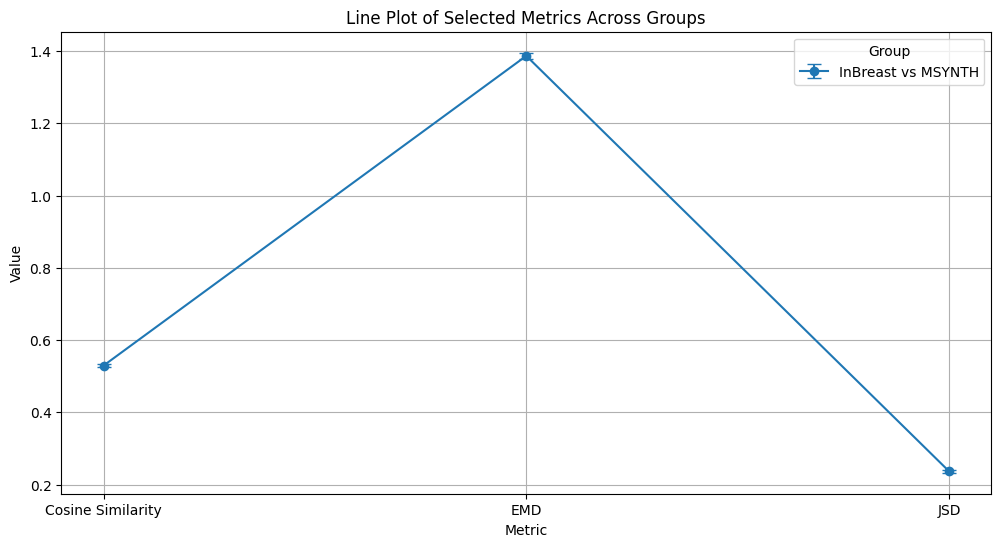

In [ ]:
# Extracting data for visualization
metric_keys = ['Cosine Similarity', 'EMD', 'JSD']
data_for_plot = {
    'Metric': [],
    'Group': [],
    'Value': [],
    'Error': []
}

for result in results:
    for metric in metric_keys:
        data_for_plot['Metric'].append(metric)
        data_for_plot['Group'].append(f"{result['Real Dataset']} vs {result['Synthetic Dataset']}")
        data_for_plot['Value'].append(float(result[f'{metric} Mean']))
        data_for_plot['Error'].append(float(result[f'{metric} ± Std'].split(' ± ')[1]))

# Convert to DataFrame
df_plot = pd.DataFrame(data_for_plot)

# Plot
plt.figure(figsize=(12, 6))

for group in df_plot['Group'].unique():
    group_data = df_plot[df_plot['Group'] == group]
    plt.errorbar(group_data['Metric'], group_data['Value'], yerr=group_data['Error'], label=group, capsize=5, fmt='-o')

plt.title('Line Plot of Selected Metrics Across Groups')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(title='Group')
plt.grid(True)
plt.show()
